# Deep Neural Network with PyTorch
**Notebook 2 of 3**

In our previous tutorial, we explored the fundamentals of deep neural networks (DNN) by implementing them from scratch using NumPy.  We delved into the mathematical foundations, learned about the backpropagation algorithm,and built a learning DNN model.<br>
In this tutorial, we will leverage out knowledge from the previous implementation and transition to using PyTorch for building and training DNNs.  This time, we will use the iris dataset contained in the sklearn library which we have become familiar with in previous tutorials.  Information about it can be found at this link [iris dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)

## Learning Objectives

Average time to complete: 20min

By the end of this tutorial you should be able to:
* Apply the notions we learned in notebook 1.
* Implement simple neural networks using a real dataset and PyTorch libraries.
* Explore and analyze the neural network to understand how well it performs.

## What you will need for this tutorial

* See the [introduction document](https://uottawa-it-research-teaching.github.io/machinelearning/) for general requirements and how Jupyter notebooks work.
* We'll need Pandas for convenient data handling. It's a very powerful Python package that can read CSV and Excel files. It also has very good data manipulation capabilities which come in use for data cleaning.
* Pytorch
* We will use scikit learn as our machine learning package.
* numpy 
* seaborn 
* matplotlib
* requests
* ipywidgets
* The data files that should have come with this notebook.

## RDM best practices

Good data handling for machine learning begins with good Research Data Managment (RDM). The quality of your source data will impact the outcome of your results, just like the reproducibility of your results will depend on the quality of your data sources, in addition to how you organize the data so that other people (and machines!) can understand and reuse it. 

We also need to respect a few research data management best practices along the way, these best practices are recommended by the [Digital Research Alliance of Canada](https://zenodo.org/records/4000989).

SAVE YOUR RAW DATA IN ORIGINAL FORMAT
* Don't overwrite your original data with a cleaned version.
* Protect your original data by locking them or making them read-only.
* Refer to this original data if things go wrong (as they often do).

BACKUP YOUR DATA
* Use the 3-2-1 rule: Save three copies of your data, on two different storage mediums, and one copy off site. The off site storage can be OneDrive or Google drive or whatever your institution provides.
* We are using Open Data, so it does not contain any personally identifiable data or data that needs to be restricted or protected in any way. However, if your data contains confidential information, it is important to take steps to restrict access and encrypt your data.

There are a few more RDM best practices that will help you in your project management, and we will highlight them at the beginning of each tutorial. 

### Building a simple neural network

We start by loading our libraries and the iris dataset from sklearn.

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable

from torch.autograd import Variable
from sklearn.datasets import load_iris

# Custom DataSet
from data import iris

### The Dataset

![iris](data/iris.jpg)

The **Iris** flower, image source: [Wikipedia](https://en.wikipedia.org/wiki/Iris_(plant))


| sepal_length_cm | sepal_width_cm | petal_length_cm | petal_width_cm | class           |
|-----------------|----------------|-----------------|----------------|-----------------|
| 5.1             | 3.5            | 1.4             | 0.2            | Iris-setosa     |
| 7.0             | 3.2            | 4.7             | 1.4            | Iris-versicolor |
| 6.3             | 3.3            | 6.0             | 2.5            | Iris-virginica  |


* Total instances: 150 (we have separated 20% into validation set, rest into training set)


#### Let's do a head on the raw file to make sure we can read the dataset properly

In [2]:
#!head data/iris.data.txt
dataset = pd.read_csv('./data/iris.data.txt')
dataset.head(5)

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### Create the Fully Connected Feed Forward Neural Network

**Create the model**

In [3]:
#Set up the Neural Network
class IrisNet(nn.Module):
    
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

The model above is created in 2 parts:<br>
<b>init<b><br>
 * It takes 3 arguments: input_size (teh number of input features), hidden_size (the number of neurons in the hidden layer), and num_classes (the number of possible output classes).
 * Inside, we define the layers of the neural network using PyTorch's nn module
 * self.fc1 is a fully conected linear layer that takes the input features and maps them to the hidden layer
 * self.relu is a ReLu activation function, which introduces non-linearily to the network (see notebooks 1)
 * self.fc2 is another fully connected linear layer that maps the hidden layer to the output classes.
    
<br><b>forward<b>
 * The x argument represents the input data
 * The forward function sapplied the layers defined in the init functions in the correct order
 * First, it passes the input x through self.fc1 to obtain the output of the first linear layer
 * Then, it applies the ReLu activation function to the output using self.relu
 * Finally, it passes the activated output through self.fc2 to obtain the final output predictions.

**Print the model**

This code shows the number of inputs and outputs for each layer

In [4]:
# Neural Network model params and NN connections
model = IrisNet(4, 100, 50, 3)
print(model)

IrisNet(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


### Our Neural Network looks like this
![](pynb_pics/pytorch_NN.jpg)

### Create the DataLoader

We train in batches of 60 samples.  This saves memory and computing resources for large datasets
BUT the smaller the batch the less accurate the estimate of the gradient will be !

In [5]:
batch_size = 60 
iris_data_file = 'data/iris.data.txt'


To use the model, we have to create our training data and test data variables on an 80/20 split.

For the training data (80%), we have<br>
    - train_ds which contains the feature X variables: sepal_length, sepal_width, petal_length, petal_width, and target lables Y class
    
For the test data (20%), we have<br>
    - test_ds which contains the feature X variables: sepal_length, sepal_width, petal_length, petal_width, and target lables Y class

In [6]:
# Get the datasets - default 80/20 split
train_ds, test_ds = iris.get_datasets(iris_data_file)

# How many instances have we got?
print('# instances in training set: ', len(train_ds))
print('# instances in testing/validation set: ', len(test_ds))

# Create the dataloaders - for training and validation/testing
# We will be using the term validation and testing data interchangably
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

# instances in training set:  120
# instances in testing/validation set:  30


### Set up the network, the loss function and the optimizer

Set up to use Pytorch for training the model on our dataset.
Note that we can specify the learning rate

In [7]:
# Our model
net = IrisNet(4, 100, 50, 3)

# Out loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, nesterov=True, momentum=0.9, dampening=0)  

### Train it!

We will go through 60 pass-through iterations of the model

In [8]:
num_epochs = 60 # These are the iterations

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    
    train_correct = 0
    train_total = 0
    
    for i, (items, classes) in enumerate(train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        
        classes = Variable(classes)
        classes = classes.to(torch.long)
        # print(classes)
        net.train()           # Put the network into training mode
        
        optimizer.zero_grad() # Clear off the gradients from any past operation
        outputs = net(items)  # Do the forward pass
        
        loss = criterion(outputs, classes) # Calculate the loss
        loss.backward()       # Calculate the gradients with help of back propagation
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data
        train_total += classes.size(0)    
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == classes.data).sum()

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
#              %(epoch+1, num_epochs, i+1, len(train_ds)//batch_size, loss.data[0]))
               %(epoch+1, num_epochs, i+1, len(train_ds)//batch_size, loss.item()))

    net.eval()                 # Put the network into evaluation mode
    
    # Book keeping
    # Record the loss
#    train_loss.append(loss.data[0])
    train_loss.append(loss.item())

    # What was our train accuracy?
    train_accuracy.append((100 * train_correct / train_total))
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    test_items = torch.FloatTensor(test_ds.data.values[:, 0:4])
    test_classes = torch.LongTensor(test_ds.data.values[:, 4])

    outputs = net(Variable(test_items))
   
    loss = criterion(outputs, Variable(test_classes))
#    test_loss.append(loss.data[0])
    test_loss.append(loss.item())
    _, predicted = torch.max(outputs.data, 1)
    total = test_classes.size(0)
    correct = (predicted == test_classes).sum()
    test_accuracy.append((100 * correct / total))

Epoch 1/60, Iteration 1/2, Loss: 1.1024
Epoch 1/60, Iteration 2/2, Loss: 1.1154
Epoch 2/60, Iteration 1/2, Loss: 1.1037
Epoch 2/60, Iteration 2/2, Loss: 1.0999
Epoch 3/60, Iteration 1/2, Loss: 1.1138
Epoch 3/60, Iteration 2/2, Loss: 1.0742
Epoch 4/60, Iteration 1/2, Loss: 1.0923
Epoch 4/60, Iteration 2/2, Loss: 1.0765
Epoch 5/60, Iteration 1/2, Loss: 1.0796
Epoch 5/60, Iteration 2/2, Loss: 1.0723
Epoch 6/60, Iteration 1/2, Loss: 1.0704
Epoch 6/60, Iteration 2/2, Loss: 1.0642
Epoch 7/60, Iteration 1/2, Loss: 1.0717
Epoch 7/60, Iteration 2/2, Loss: 1.0472
Epoch 8/60, Iteration 1/2, Loss: 1.0517
Epoch 8/60, Iteration 2/2, Loss: 1.0482
Epoch 9/60, Iteration 1/2, Loss: 1.0483
Epoch 9/60, Iteration 2/2, Loss: 1.0350
Epoch 10/60, Iteration 1/2, Loss: 1.0499
Epoch 10/60, Iteration 2/2, Loss: 1.0165
Epoch 11/60, Iteration 1/2, Loss: 1.0369
Epoch 11/60, Iteration 2/2, Loss: 1.0123
Epoch 12/60, Iteration 1/2, Loss: 1.0151
Epoch 12/60, Iteration 2/2, Loss: 1.0178
Epoch 13/60, Iteration 1/2, Loss: 

Plot loss vs iterations

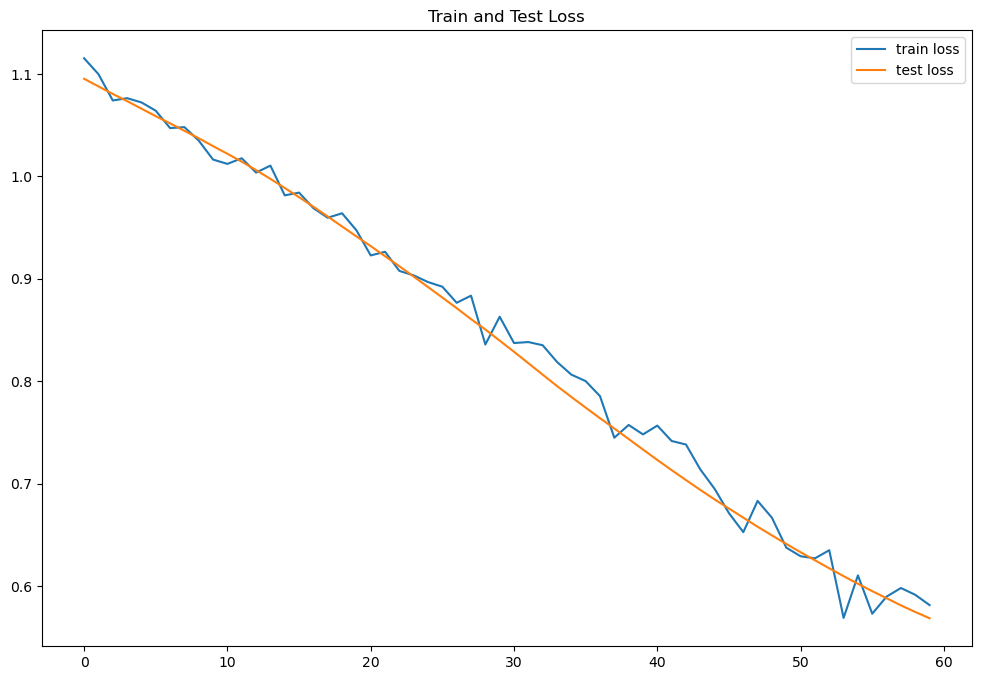

In [9]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title("Train and Test Loss")
plt.legend()
plt.show()

We notice that the loss (error) for the unseen data (test set) is lower than the training set.  That's a good indication that the model is performing well.

Plot Accuracy vs iterations

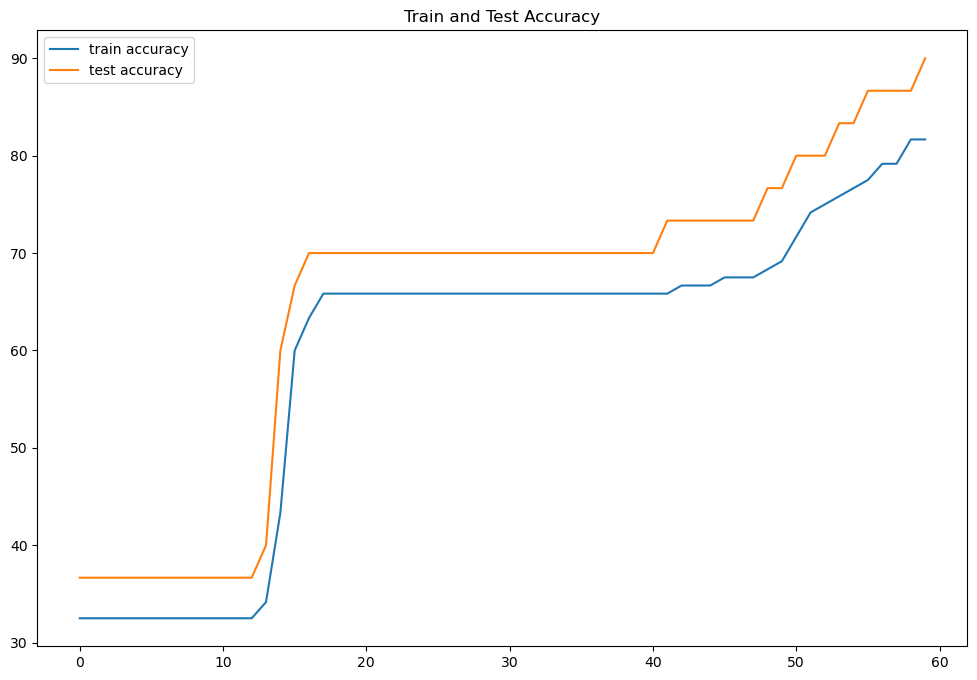

In [12]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
plt.legend()
plt.show()

Our model is reaching abover 90% accuracy.  That's very good

### Saving the model to disk, and loading it back

In [13]:
torch.save(net.state_dict(), "./2.model.pth")

In [14]:
net2 = IrisNet(4, 100, 50, 3)
net2.load_state_dict(torch.load("./2.model.pth"))

<All keys matched successfully>

Choose which values of features you want the model to predict on.  Recall from our last tutorials that the most significant features of the iris flower are the petal length and width

In [15]:
# output = net2(Variable(torch.FloatTensor([[5.1, 3.5, 1.4, 0.2]]))) # Iris-setosa
# output = net2(Variable(torch.FloatTensor([[7.0, 3.2, 4.7, 1.4]]))) # Iris-versicolor
#output = net2(Variable(torch.FloatTensor([[6.3, 3.3, 6.0, 2.5]])))  # Iris-virginica
output = net2(Variable(torch.FloatTensor([[5.0, 2.2, 5.7, 4.4]]))) # Random feature sizes

### Test

In [16]:
_, predicted_class = torch.max(output.data, 1)

print('Predicted class: ', predicted_class.numpy()[0])
print('0: Iris-setosa ')
print('1: Iris-versicolor ')
print('2: Iris-virginica ')

Predicted class:  2
0: Iris-setosa 
1: Iris-versicolor 
2: Iris-virginica 


Check if your predictions are correct by looking in the dataset

## Please proceed to Notebook 3 - CNN Concepts